<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [IMDB1] - Sentiment analysis with hot-one encoding
<!-- DESC --> A basic example of sentiment analysis with sparse encoding, using a dataset from Internet Movie Database (IMDB)
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - The objective is to guess whether film reviews are **positive or negative** based on the analysis of the text. 
 - Understand the management of **textual data** and **sentiment analysis**

Original dataset can be find **[there](http://ai.stanford.edu/~amaas/data/sentiment/)**  
Note that [IMDb.com](https://imdb.com) offers several easy-to-use [datasets](https://www.imdb.com/interfaces/)  
For simplicity's sake, we'll use the dataset directly [embedded in Keras](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)

## What we're going to do :

 - Retrieve data
 - Preparing the data
 - Build a model
 - Train the model
 - Evaluate the result


## Step 1 - Import and init
### 1.1 - Python stuff

In [1]:
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.datasets.imdb as imdb

import matplotlib.pyplot as plt
import matplotlib

import pandas as pd

import os,sys,h5py,json
from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/IMDB1'
datasets_dir = pwk.init('IMDB1', run_dir)

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.17
Notebook id          : IMDB1
Run time             : Monday 01 March 2021, 20:19:48
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run/IMDB1
Update keras cache   : False
Save figs            : True
Path figs            : ./run/IMDB1/figs


### 1.2 - Parameters
The words in the vocabulary are classified from the most frequent to the rarest.  
`vocab_size` is the number of words we will remember in our vocabulary (the other words will be considered as unknown).  
`hide_most_frequently` is the number of ignored words, among the most common ones  

In [2]:
vocab_size           = 10000
hide_most_frequently = 0

epochs     = 10
batch_size = 512

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('vocab_size', 'hide_most_frequently', 'batch_size', 'epochs')

## Step 2 - Understanding hot-one encoding
#### We have a **sentence** and a **dictionary** :

In [4]:
sentence = "I've never seen a movie like this before"

dictionary  = {"a":0, "before":1, "fantastic":2, "i've":3, "is":4, "like":5, "movie":6, "never":7, "seen":8, "this":9}

#### We encode our sentence as a **numerical vector** :

In [5]:
sentence_words = sentence.lower().split()

sentence_vect  = [ dictionary[w] for w in sentence_words ]

print('Words sentence are         : ', sentence_words)
print('Our vectorized sentence is : ', sentence_vect)

Words sentence are         :  ["i've", 'never', 'seen', 'a', 'movie', 'like', 'this', 'before']
Our vectorized sentence is :  [3, 7, 8, 0, 6, 5, 9, 1]


#### Next, we **one-hot** encode our vectorized sentence as a tensor :

In [6]:
# ---- We get a (sentence length x vector size) matrix of zeros
#
onehot = np.zeros( (10,8) )

# ---- We set some 1 for each word
#
for i,w in enumerate(sentence_vect):
    onehot[w,i]=1

# --- Show it
#
print('In a basic way :\n\n', onehot, '\n\nWith a pandas wiew :\n')
data={ f'{sentence_words[i]:.^10}':onehot[:,i] for i,w in enumerate(sentence_vect) }
df=pd.DataFrame(data)
df.index=dictionary.keys()
df.style.set_precision(0).highlight_max(axis=0).set_properties(**{'text-align': 'center'})

In a basic way :

 [[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]] 

With a pandas wiew :



,...i've...,..never...,...seen...,....a.....,..movie...,...like...,...this...,..before..
a,0,0,0,1,0,0,0,0
before,0,0,0,0,0,0,0,1
fantastic,0,0,0,0,0,0,0,0
i've,1,0,0,0,0,0,0,0
is,0,0,0,0,0,0,0,0
like,0,0,0,0,0,1,0,0
movie,0,0,0,0,1,0,0,0
never,0,1,0,0,0,0,0,0
seen,0,0,1,0,0,0,0,0
this,0,0,0,0,0,0,1,0


## Step 3 - Retrieve data

IMDb dataset can bet get directly from Keras - see [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)  
Note : Due to their nature, textual data can be somewhat complex.

### 3.1 - Data structure :  
The dataset is composed of 2 parts: 

 - **reviews**, this will be our **x**
 - **opinions** (positive/negative), this will be our **y**

There are also a **dictionary**, because words are indexed in reviews

```
<dataset> = (<reviews>, <opinions>)

with :  <reviews>  = [ <review1>, <review2>, ... ]
        <opinions> = [ <rate1>,   <rate2>,   ... ]   where <ratei>   = integer

where : <reviewi> = [ <w1>, <w2>, ...]    <wi> are the index (int) of the word in the dictionary
        <ratei>   = int                   0 for negative opinion, 1 for positive


<dictionary> = [ <word1>:<w1>, <word2>:<w2>, ... ]

with :  <wordi>   = word
        <wi>      = int

```

### 3.2 - Load dataset
For simplicity, we will use a pre-formatted dataset - See [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data)  
However, Keras offers some usefull tools for formatting textual data - See [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text)  

By default : 
 - Start of a sequence will be marked with : 1
 - Out of vocabulary word will be : 2
 - First index will be : 3

In [7]:
# ----- Retrieve x,y
#
(x_train, y_train), (x_test, y_test) = imdb.load_data( num_words=vocab_size, skip_top=hide_most_frequently)

y_train = np.asarray(y_train).astype('float32')
y_test  = np.asarray(y_test ).astype('float32')

# ---- About
#
print("Max(x_train,x_test)  : ", pwk.rmax([x_train,x_test]) )
print("Min(x_train,x_test)  : ", pwk.rmin([x_train,x_test]) )
print("x_train : {}  y_train : {}".format(x_train.shape, y_train.shape))
print("x_test  : {}  y_test  : {}".format(x_test.shape,  y_test.shape))

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


/gpfslocalsup/pub/anaconda-py3/2020.02/envs/tensorflow-gpu-2.4.0/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


/gpfslocalsup/pub/anaconda-py3/2020.02/envs/tensorflow-gpu-2.4.0/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


Max(x_train,x_test)  :  9999


Min(x_train,x_test)  :  1
x_train : (25000,)  y_train : (25000,)
x_test  : (25000,)  y_test  : (25000,)


## Step 4 - About our dataset
When we loaded the dataset, we asked for using \<start\> as 1, \<unknown word\> as 2  
So, we shifted the dataset by 3 with the parameter index_from=3

### 4.1 - Sentences encoding

In [8]:
print('\nReview example (x_train[12]) :\n\n',x_train[12])
print('\nOpinions (y_train) :\n\n',y_train)


Review example (x_train[12]) :

 [1, 13, 119, 954, 189, 1554, 13, 92, 459, 48, 4, 116, 9, 1492, 2291, 42, 726, 4, 1939, 168, 2031, 13, 423, 14, 20, 549, 18, 4, 2, 547, 32, 4, 96, 39, 4, 454, 7, 4, 22, 8, 4, 55, 130, 168, 13, 92, 359, 6, 158, 1511, 2, 42, 6, 1913, 19, 194, 4455, 4121, 6, 114, 8, 72, 21, 465, 9667, 304, 4, 51, 9, 14, 20, 44, 155, 8, 6, 226, 162, 616, 651, 51, 9, 14, 20, 44, 10, 10, 14, 218, 4843, 629, 42, 3017, 21, 48, 25, 28, 35, 534, 5, 6, 320, 8, 516, 5, 42, 25, 181, 8, 130, 56, 547, 3571, 5, 1471, 851, 14, 2286]

Opinions (y_train) :

 [1. 0. 0. ... 0. 1. 0.]


### 4.2 - Load dictionary

In [9]:
# ---- Retrieve dictionary {word:index}, and encode it in ascii
#
word_index = imdb.get_word_index()

# ---- Shift the dictionary from +3
#
word_index = {w:(i+3) for w,i in word_index.items()}

# ---- Add <pad>, <start> and <unknown> tags
#
word_index.update( {'<pad>':0, '<start>':1, '<unknown>':2, '<undef>':3,} )

# ---- Create a reverse dictionary : {index:word}
#
index_word = {index:word for word,index in word_index.items()} 

# ---- About dictionary
#
print('\nDictionary size     : ', len(word_index))
print('\nSmall extract :\n')
for k in range(440,455):print(f'    {k:2d} : {index_word[k]}' )

# ---- Add a nice function to transpose :
#
def dataset2text(review):
    return ' '.join([index_word.get(i, '?') for i in review])


Dictionary size     :  88588

Small extract :

    440 : hope
    441 : entertaining
    442 : she's
    443 : mr
    444 : overall
    445 : evil
    446 : called
    447 : loved
    448 : based
    449 : oh
    450 : several
    451 : fans
    452 : mother
    453 : drama
    454 : beginning


### 4.3 - Have a look, for human

In [10]:
pwk.subtitle('Review example :')
print(x_train[12])
pwk.subtitle('After translation :')
print(dataset2text(x_train[12]))

<br>**Review example :**

[1, 13, 119, 954, 189, 1554, 13, 92, 459, 48, 4, 116, 9, 1492, 2291, 42, 726, 4, 1939, 168, 2031, 13, 423, 14, 20, 549, 18, 4, 2, 547, 32, 4, 96, 39, 4, 454, 7, 4, 22, 8, 4, 55, 130, 168, 13, 92, 359, 6, 158, 1511, 2, 42, 6, 1913, 19, 194, 4455, 4121, 6, 114, 8, 72, 21, 465, 9667, 304, 4, 51, 9, 14, 20, 44, 155, 8, 6, 226, 162, 616, 651, 51, 9, 14, 20, 44, 10, 10, 14, 218, 4843, 629, 42, 3017, 21, 48, 25, 28, 35, 534, 5, 6, 320, 8, 516, 5, 42, 25, 181, 8, 130, 56, 547, 3571, 5, 1471, 851, 14, 2286]


<br>**After translation :**

<start> i love cheesy horror flicks i don't care if the acting is sub par or whether the monsters look corny i liked this movie except for the <unknown> feeling all the way from the beginning of the film to the very end look i don't need a 10 page <unknown> or a sign with big letters explaining a plot to me but dark floors takes the what is this movie about thing to a whole new annoying level what is this movie about br br this isn't exceptionally scary or thrilling but if you have an hour and a half to kill and or you want to end up feeling frustrated and confused rent this winner


### 4.4 - Few statistics

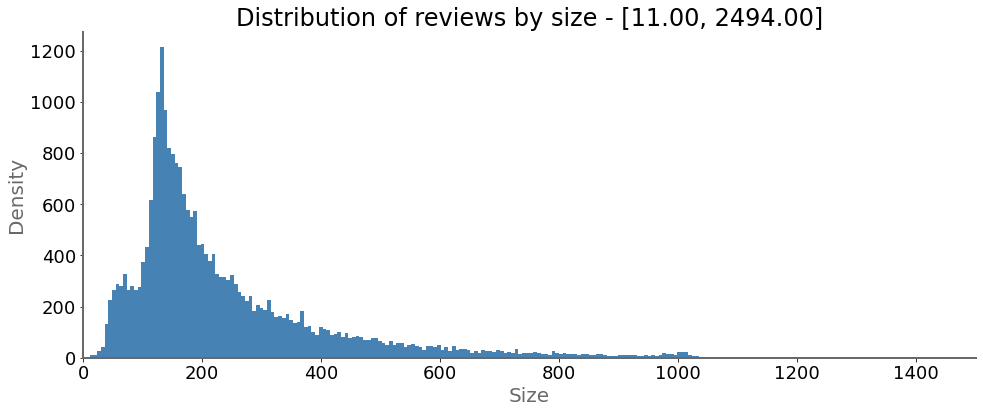

In [11]:
sizes=[len(i) for i in x_train]
plt.figure(figsize=(16,6))
plt.hist(sizes, bins=400)
plt.gca().set(title='Distribution of reviews by size - [{:5.2f}, {:5.2f}]'.format(min(sizes),max(sizes)), 
              xlabel='Size', ylabel='Density', xlim=[0,1500])
pwk.save_fig('01-stats-sizes')
plt.show()

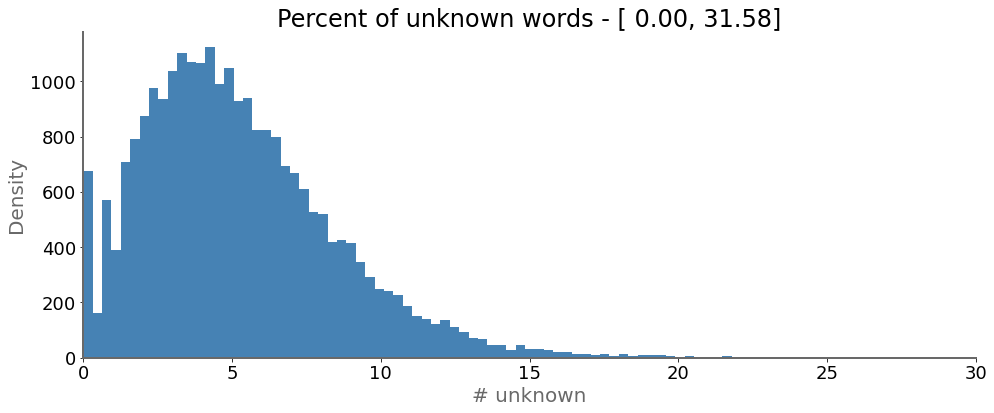

In [12]:
unk=[ 100*(s.count(2)/len(s)) for s in x_train]
plt.figure(figsize=(16,6))
plt.hist(unk, bins=100)
plt.gca().set(title='Percent of unknown words - [{:5.2f}, {:5.2f}]'.format(min(unk),max(unk)), 
              xlabel='# unknown', ylabel='Density', xlim=[0,30])
pwk.save_fig('02-stats-unknown')
plt.show()

## Step 5 - Basic approach with "one-hot" vector encoding
Basic approach.  

Each sentence is encoded with a **vector** of length equal to the **size of the dictionary**.   

Each sentence will therefore be encoded with a simple vector.  
The value of each component is 0 if the word is not present in the sentence or 1 if the word is present.

For a sentence s=[3,4,7] and a dictionary of 10 words...    
We wil have a vector v=[0,0,0,1,1,0,0,1,0,0,0]



### 5.1 - Our one-hot encoder

In [13]:
def one_hot_encoder(x, vector_size=10000):
    
    # ---- Set all to 0
    #
    x_encoded = np.zeros((len(x), vector_size))
    
    # ---- For each sentence
    #
    for i,sentence in enumerate(x):
        for word in sentence:
            x_encoded[i, word] = 1.

    return x_encoded

### 5.2 - Encoding..

In [14]:
x_train = one_hot_encoder(x_train)
x_test  = one_hot_encoder(x_test)

print("To have a look, x_train[12] became :", x_train[12] )

To have a look, x_train[12] became : [0. 1. 1. ... 0. 0. 0.]


## Step 6 - Build the model
Few remarks :
 - We'll choose a dense vector size for the embedding output with **dense_vector_size**
 - **GlobalAveragePooling1D** do a pooling on the last dimension : (None, lx, ly) -> (None, ly)  
   In other words: we average the set of vectors/words of a sentence
 - L'embedding de Keras fonctionne de manière supervisée. Il s'agit d'une couche de *vocab_size* neurones vers *n_neurons* permettant de maintenir une table de vecteurs (les poids constituent les vecteurs). Cette couche ne calcule pas de sortie a la façon des couches normales, mais renvois la valeur des vecteurs. n mots => n vecteurs (ensuite empilés par le pooling)  
Voir : [Explication plus détaillée (en)](https://stats.stackexchange.com/questions/324992/how-the-embedding-layer-is-trained-in-keras-embedding-layer)  
ainsi que : [Sentiment detection with Keras](https://www.liip.ch/en/blog/sentiment-detection-with-keras-word-embeddings-and-lstm-deep-learning-networks)  

More documentation about this model functions :
 - [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)
 - [GlobalAveragePooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D)

In [15]:
def get_model(vector_size=10000):
    
    model = keras.Sequential()
    model.add(keras.layers.Input( shape=(vector_size,) ))
    model.add(keras.layers.Dense( 32, activation='relu'))
    model.add(keras.layers.Dense( 32, activation='relu'))
    model.add(keras.layers.Dense( 1, activation='sigmoid'))
    
    model.compile(optimizer = 'rmsprop',
                  loss      = 'binary_crossentropy',
                  metrics   = ['accuracy'])
    return model

## Step 7 - Train the model
### 7.1 - Get it

In [16]:
model = get_model(vector_size=vocab_size)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 321,121
Trainable params: 321,121
Non-trainable params: 0
_________________________________________________________________


### 7.2 - Add callback

In [17]:
os.makedirs(f'{run_dir}/models',   mode=0o750, exist_ok=True)
save_dir = f'{run_dir}/models/best_model.h5'
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 7.3 - Train it

In [18]:
%%time

history = model.fit(x_train,
                    y_train,
                    epochs          = epochs,
                    batch_size      = batch_size,
                    validation_data = (x_test, y_test),
                    verbose         = 1,
                    callbacks       = [savemodel_callback])


Epoch 1/10


 1/49 [..............................] - ETA: 59s - loss: 0.6934 - accuracy: 0.4922

 9/49 [====>.........................] - ETA: 0s - loss: 0.6659 - accuracy: 0.5854 

17/49 [=========>....................] - ETA: 0s - loss: 0.6317 - accuracy: 0.6423

25/49 [==============>...............] - ETA: 0s - loss: 0.6021 - accuracy: 0.6791

33/49 [===================>..........] - ETA: 0s - loss: 0.5771 - accuracy: 0.7048

41/49 [========================>.....] - ETA: 0s - loss: 0.5562 - accuracy: 0.7239

49/49 [==============================] - ETA: 0s - loss: 0.5377 - accuracy: 0.7391

49/49 [==============================] - 4s 50ms/step - loss: 0.5357 - accuracy: 0.7407 - val_loss: 0.3431 - val_accuracy: 0.8612


Epoch 2/10
 1/49 [..............................] - ETA: 0s - loss: 0.3098 - accuracy: 0.8945

 9/49 [====>.........................] - ETA: 0s - loss: 0.2747 - accuracy: 0.9082

17/49 [=========>....................] - ETA: 0s - loss: 0.2679 - accuracy: 0.9094

25/49 [==============>...............] - ETA: 0s - loss: 0.2639 - accuracy: 0.9098

33/49 [===================>..........] - ETA: 0s - loss: 0.2616 - accuracy: 0.9096

41/49 [========================>.....] - ETA: 0s - loss: 0.2590 - accuracy: 0.9098

49/49 [==============================] - ETA: 0s - loss: 0.2569 - accuracy: 0.9100

49/49 [==============================] - 1s 15ms/step - loss: 0.2567 - accuracy: 0.9100 - val_loss: 0.2928 - val_accuracy: 0.8822


Epoch 3/10
 1/49 [..............................] - ETA: 0s - loss: 0.2240 - accuracy: 0.9062

 9/49 [====>.........................] - ETA: 0s - loss: 0.2043 - accuracy: 0.9177

17/49 [=========>....................] - ETA: 0s - loss: 0.1958 - accuracy: 0.9244

25/49 [==============>...............] - ETA: 0s - loss: 0.1950 - accuracy: 0.9259

33/49 [===================>..........] - ETA: 0s - loss: 0.1948 - accuracy: 0.9264

41/49 [========================>.....] - ETA: 0s - loss: 0.1944 - accuracy: 0.9267

49/49 [==============================] - ETA: 0s - loss: 0.1944 - accuracy: 0.9269

49/49 [==============================] - 1s 15ms/step - loss: 0.1943 - accuracy: 0.9269 - val_loss: 0.3029 - val_accuracy: 0.8792


Epoch 4/10
 1/49 [..............................] - ETA: 0s - loss: 0.1716 - accuracy: 0.9297

 9/49 [====>.........................] - ETA: 0s - loss: 0.1571 - accuracy: 0.9390

17/49 [=========>....................] - ETA: 0s - loss: 0.1584 - accuracy: 0.9399

25/49 [==============>...............] - ETA: 0s - loss: 0.1566 - accuracy: 0.9415

33/49 [===================>..........] - ETA: 0s - loss: 0.1554 - accuracy: 0.9424

41/49 [========================>.....] - ETA: 0s - loss: 0.1556 - accuracy: 0.9424

49/49 [==============================] - ETA: 0s - loss: 0.1561 - accuracy: 0.9422

49/49 [==============================] - 1s 15ms/step - loss: 0.1562 - accuracy: 0.9421 - val_loss: 0.3046 - val_accuracy: 0.8800


Epoch 5/10
 1/49 [..............................] - ETA: 0s - loss: 0.1178 - accuracy: 0.9648

 9/49 [====>.........................] - ETA: 0s - loss: 0.1286 - accuracy: 0.9588

17/49 [=========>....................] - ETA: 0s - loss: 0.1313 - accuracy: 0.9556

25/49 [==============>...............] - ETA: 0s - loss: 0.1303 - accuracy: 0.9557

33/49 [===================>..........] - ETA: 0s - loss: 0.1309 - accuracy: 0.9553

41/49 [========================>.....] - ETA: 0s - loss: 0.1315 - accuracy: 0.9548

49/49 [==============================] - ETA: 0s - loss: 0.1322 - accuracy: 0.9544

49/49 [==============================] - 1s 15ms/step - loss: 0.1323 - accuracy: 0.9543 - val_loss: 0.3529 - val_accuracy: 0.8702


Epoch 6/10
 1/49 [..............................] - ETA: 0s - loss: 0.1115 - accuracy: 0.9531

 9/49 [====>.........................] - ETA: 0s - loss: 0.1190 - accuracy: 0.9563

17/49 [=========>....................] - ETA: 0s - loss: 0.1154 - accuracy: 0.9592

25/49 [==============>...............] - ETA: 0s - loss: 0.1145 - accuracy: 0.9599

33/49 [===================>..........] - ETA: 0s - loss: 0.1154 - accuracy: 0.9592

41/49 [========================>.....] - ETA: 0s - loss: 0.1159 - accuracy: 0.9588

49/49 [==============================] - ETA: 0s - loss: 0.1161 - accuracy: 0.9585

49/49 [==============================] - 1s 14ms/step - loss: 0.1162 - accuracy: 0.9585 - val_loss: 0.3627 - val_accuracy: 0.8725


Epoch 7/10
 1/49 [..............................] - ETA: 0s - loss: 0.0747 - accuracy: 0.9805

 9/49 [====>.........................] - ETA: 0s - loss: 0.0813 - accuracy: 0.9764

17/49 [=========>....................] - ETA: 0s - loss: 0.0861 - accuracy: 0.9733

25/49 [==============>...............] - ETA: 0s - loss: 0.0877 - accuracy: 0.9722

33/49 [===================>..........] - ETA: 0s - loss: 0.0894 - accuracy: 0.9710

41/49 [========================>.....] - ETA: 0s - loss: 0.0909 - accuracy: 0.9701

49/49 [==============================] - ETA: 0s - loss: 0.0922 - accuracy: 0.9693

49/49 [==============================] - 1s 15ms/step - loss: 0.0923 - accuracy: 0.9693 - val_loss: 0.3997 - val_accuracy: 0.8669


Epoch 8/10
 1/49 [..............................] - ETA: 0s - loss: 0.0807 - accuracy: 0.9766

 9/49 [====>.........................] - ETA: 0s - loss: 0.0709 - accuracy: 0.9798

17/49 [=========>....................] - ETA: 0s - loss: 0.0713 - accuracy: 0.9788

25/49 [==============>...............] - ETA: 0s - loss: 0.0737 - accuracy: 0.9768

33/49 [===================>..........] - ETA: 0s - loss: 0.0749 - accuracy: 0.9758

41/49 [========================>.....] - ETA: 0s - loss: 0.0762 - accuracy: 0.9750

49/49 [==============================] - ETA: 0s - loss: 0.0772 - accuracy: 0.9744

49/49 [==============================] - 1s 14ms/step - loss: 0.0773 - accuracy: 0.9743 - val_loss: 0.4484 - val_accuracy: 0.8576


Epoch 9/10
 1/49 [..............................] - ETA: 0s - loss: 0.0758 - accuracy: 0.9766

 9/49 [====>.........................] - ETA: 0s - loss: 0.0614 - accuracy: 0.9830

17/49 [=========>....................] - ETA: 0s - loss: 0.0635 - accuracy: 0.9819

25/49 [==============>...............] - ETA: 0s - loss: 0.0637 - accuracy: 0.9817

33/49 [===================>..........] - ETA: 0s - loss: 0.0645 - accuracy: 0.9812

41/49 [========================>.....] - ETA: 0s - loss: 0.0656 - accuracy: 0.9805

49/49 [==============================] - ETA: 0s - loss: 0.0661 - accuracy: 0.9800

49/49 [==============================] - 1s 14ms/step - loss: 0.0661 - accuracy: 0.9800 - val_loss: 0.5089 - val_accuracy: 0.8507


Epoch 10/10
 1/49 [..............................] - ETA: 0s - loss: 0.0721 - accuracy: 0.9844

 9/49 [====>.........................] - ETA: 0s - loss: 0.0538 - accuracy: 0.9891

17/49 [=========>....................] - ETA: 0s - loss: 0.0514 - accuracy: 0.9885

25/49 [==============>...............] - ETA: 0s - loss: 0.0537 - accuracy: 0.9864

33/49 [===================>..........] - ETA: 0s - loss: 0.0542 - accuracy: 0.9856

42/49 [========================>.....] - ETA: 0s - loss: 0.0550 - accuracy: 0.9848

49/49 [==============================] - 1s 14ms/step - loss: 0.0561 - accuracy: 0.9840 - val_loss: 0.4907 - val_accuracy: 0.8617


CPU times: user 19.1 s, sys: 2.13 s, total: 21.3 s
Wall time: 10.9 s


## Step 8 - Evaluate
### 8.1 - Training history

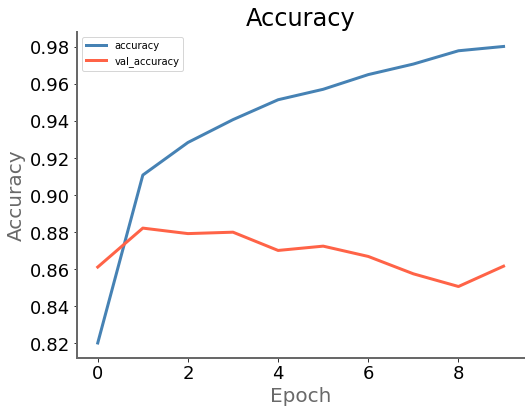

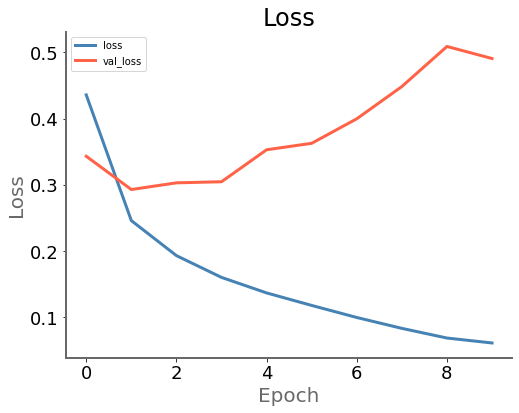

In [19]:
pwk.plot_history(history, save_as='02-history')

### 8.2 - Reload and evaluate best model

x_test / loss      : 0.2928
x_test / accuracy  : 0.8822


#### Accuracy donut is :

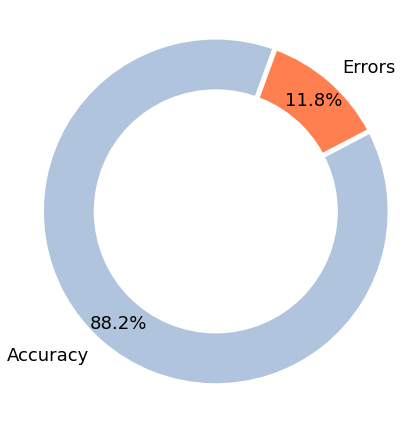

#### Confusion matrix is :

,0,1
0,0.83,0.17
1,0.07,0.93


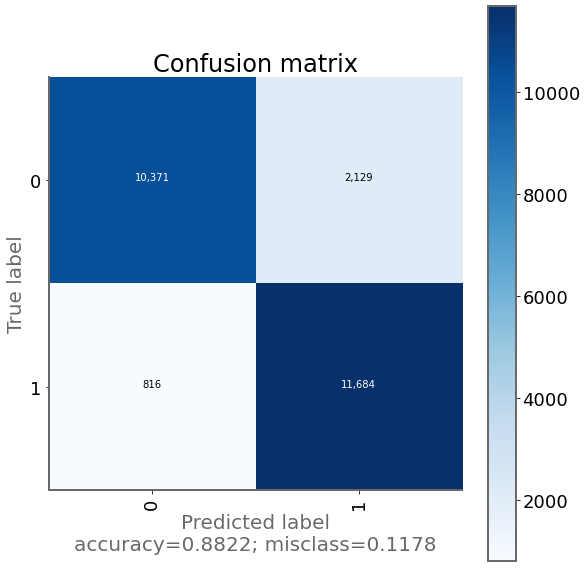

In [20]:
model = keras.models.load_model(f'{run_dir}/models/best_model.h5')

# ---- Evaluate
score  = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / accuracy  : {:5.4f}'.format(score[1]))

values=[score[1], 1-score[1]]
pwk.plot_donut(values,["Accuracy","Errors"], title="#### Accuracy donut is :", save_as='03-donut')

# ---- Confusion matrix

y_sigmoid = model.predict(x_test)

y_pred = y_sigmoid.copy()
y_pred[ y_sigmoid< 0.5 ] = 0
y_pred[ y_sigmoid>=0.5 ] = 1    

pwk.display_confusion_matrix(y_test,y_pred,labels=range(2))
pwk.plot_confusion_matrix(y_test,y_pred,range(2), figsize=(8, 8),normalize=False, save_as='04-confusion-matrix')

In [21]:
pwk.end()

End time is : Monday 01 March 2021, 20:20:30
Duration is : 00:00:41 335ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>